In [10]:
%matplotlib notebook
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from scipy import stats

df = pd.read_csv('data/human_body_temperature.csv')

In [2]:
# First take a look at the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 3 columns):
temperature    130 non-null float64
gender         130 non-null object
heart_rate     130 non-null float64
dtypes: float64(2), object(1)
memory usage: 3.1+ KB


<IPython.core.display.Javascript object>


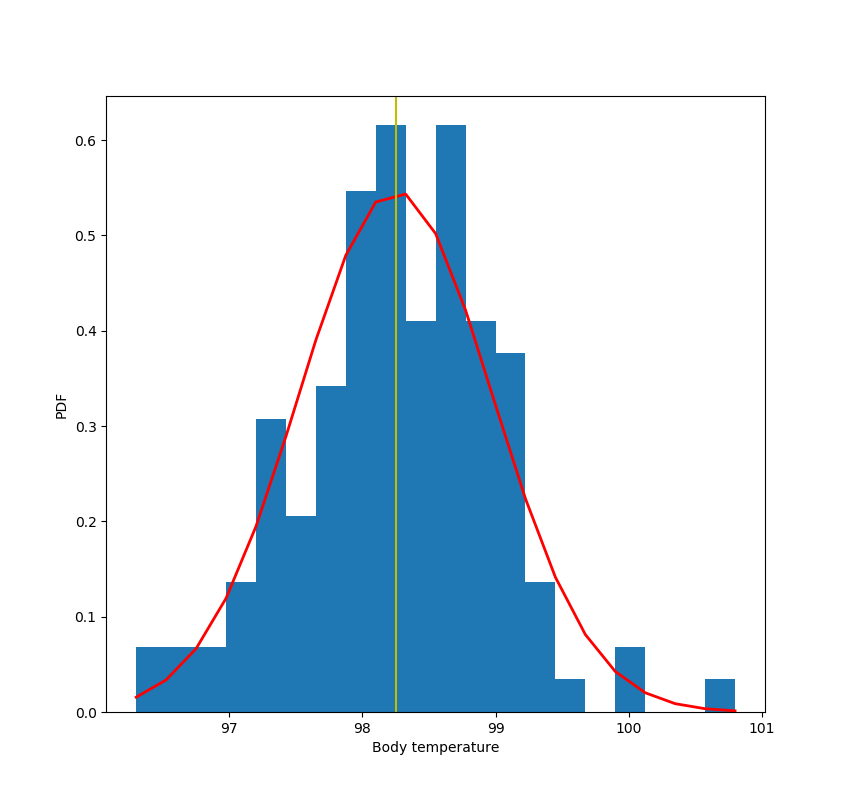

In [3]:
# The best way to take a closer look at the data is through some simple EDA
# We can try to test for normality using the graphical way
plt.figure(figsize=(8.5,8))
plt.subplot(1,1,1)
count, bins, ignored = plt.hist(df.temperature,density=True,bins=20)
mu = np.mean(df.temperature)
sigma = np.std(df.temperature)
p = np.random.normal(mu, sigma,1000)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-(bins - mu)**2 / (2 * sigma**2)), 
         linewidth=2, color='r')
plt.axvline(x=mu,color='y')
plt.xlabel('Body temperature')
plt.ylabel('PDF')
plt.show()
# Actually from our data the temperature seems "normal" in the sense where there is a visible amount of symmetry 

<IPython.core.display.Javascript object>


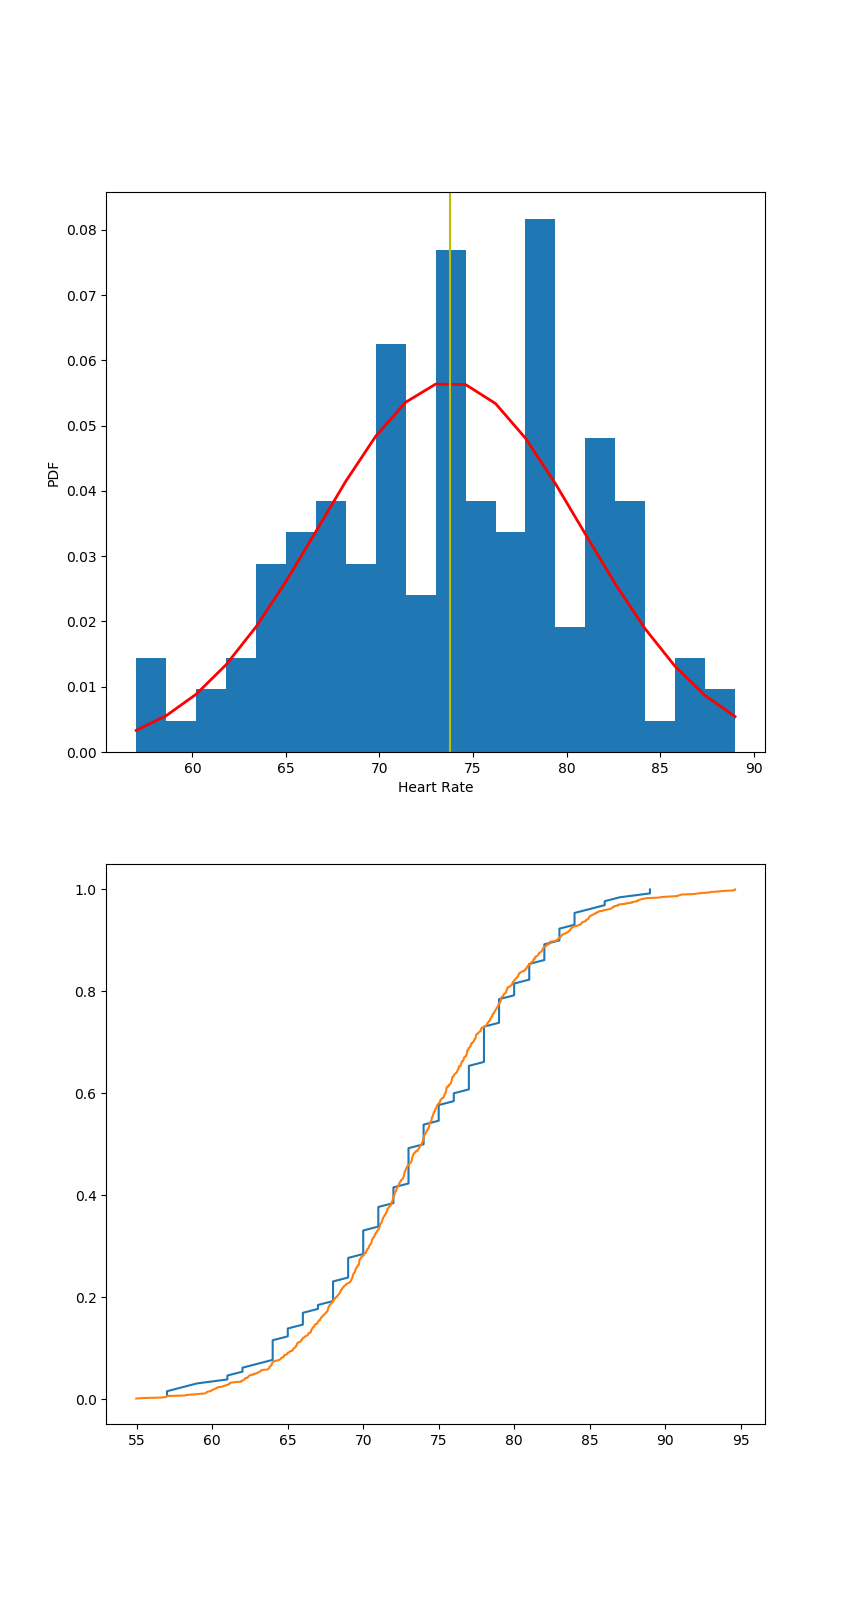

In [4]:
# Repeat the same analysis with the other two graphs to gain an understanding of both of them as well
plt.figure(figsize=(8.5,16))
plt.subplot(2,1,1)
count, bins, ignored = plt.hist(df.heart_rate,density=True,bins=20)
mu = np.mean(df.heart_rate)
sigma = np.std(df.heart_rate)
p = np.random.normal(mu, sigma,1000)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-(bins - mu)**2 / (2 * sigma**2)), 
         linewidth=2, color='r')
plt.axvline(x=mu,color='y')
plt.xlabel('Heart Rate')
plt.ylabel('PDF')
plt.show()

# This set of data is harder to see, perhaps plotting it in cumulative distribution function will be easier to see
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1,n+1) / n

    return x, y
plt.subplot(2,1,2)
x,y = ecdf(df.heart_rate)
x_norm, y_norm = ecdf(p)
plt.plot(x,y)
plt.plot(x_norm,y_norm)
plt.show()
# From this we can see a sort of fit to the normal curve though with the amount of samples
# we have this is harder to determine

The p-value 0.0 is lower than our significance level and thus we reject the null hypothesis.


<IPython.core.display.Javascript object>


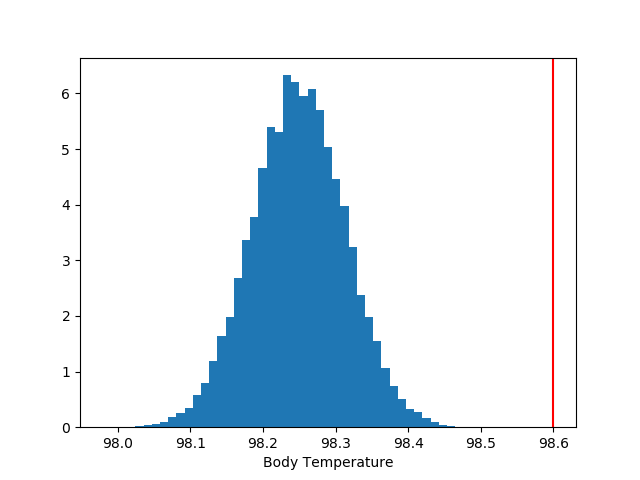

The hacked p-value 0.0 is lower than our significance level and thus we reject the null hypothesis.


In [60]:
# Determine if the true human body temperature is 98.6 first using statistics then using 
# hacker statistics through bootstrap sampling

null_h = 98.6
# Alternative hypothsis the heart rate is not 98.6 and the alpha/significance level is 0.05 or 5% 
alpha = 0.05
mu = np.mean(df.temperature)
sigma = np.std(df.temperature)
n = df.temperature.count()
t_val = (mu - null_h) / np.sqrt(sigma/float(n))
# Using t-value because we lack the standard deviation value for the population
p_val = stats.t.sf(np.abs(t_val), n-1)*2
# Another method given by scipy to provide
t2_val, p2_val = stats.ttest_1samp(df.temperature, null_h)
if(p_val < alpha):
    print(f"The p-value {np.round(p_val,2)} is lower than our significance level and thus we reject the null hypothesis.")
else:
    print(f"The p-value {np.round(p_val,2)} is higher than our significance level so we cannot reject the null hypothesis.")
    

# Lets see if we can use one sample  bootstrap testing to verify our conclusion
def draw_bs_reps(data, func, size=1):
    '''Use a one dimensional set of data to create an array of bootstrap replicates'''
    bs_replicates = np.empty(size)
    
    # Generate replicates by reorganizing the data then randomly selecting and replacing the data before running
    # the function on the data to create an array of bootstrap replicates
    for i in range(size):
        bs_replicates[i] = func(np.random.choice(data, size=len(data)))

    return bs_replicates
# We'll take 10000 resampled means to use as a test for p-value
bs_temp = draw_bs_reps(df.temperature,np.mean,50000)
plt.hist(bs_temp,bins=50,density=True)
plt.axvline(x=null_h,color='r')
plt.xlabel("Body Temperature")
plt.show()
# Although it looks fairly obvious with the graph, I will still calculate the p-value to show
# Calculate the p-value through determining the number of bootstrap replicates that are below the sample
hacked_p_value = np.sum(bs_temp>= null_h)/ len(bs_temp)

if(p_val < alpha):
    print(f"The hacked p-value {np.round(hacked_p_value,2)} is lower than our significance level and thus we reject the null hypothesis.")
else:
    print(f"The hacked p-value {np.round(hacked_p_value,2)} is higher than our significance level so we cannot reject the null hypothesis.")

In [72]:
# Determining difference of z-value vs t-value by using smaller sample size
small_temp_sample = np.random.choice(df.temperature, 10)

null_h = 98.6

mu = np.mean(small_temp_sample)
sigma = np.std(small_temp_sample)

z_val = (null_h - mu) / sigma
# Another method given by scipy to provide
t_val, p_val = stats.ttest_1samp(small_temp_sample, null_h)
print(f"The z-score {z_val} vs the t-score {t_val}")    
# There is a clear difference as the z-score is determined by assuming that our standard deviation from the
# small sample is equivalent to the population sample deviation

The z-score 0.5640444233812686 vs the t-score -1.6921332701438059
